In [29]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from aotools import *
import matplotlib.patches as patches



%matplotlib inline


telescope_diameter = .356 # meter
central_obscuration =  0.13 #.114 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
#spider_width = 0.05 # meter   ##spiders not mentioned in celestron site
oversizing_factor =  147/128 #17 / 16  #NOT SURE
focallength_t = 3.910 #m
f_number = focallength_t/telescope_diameter 

focallength_l = 0.0145 #m
sh_pitch = .0005 #m
num_lenslets = 6 # lenslets along one diameter
sh_diameter = sh_pitch * num_lenslets #m
f_number_sh = focallength_l/sh_pitch
plate_scale = 0.55 #arcsec/pixel calculated in proposal doc
# pixel_size = 3.45e-6 #m 
num_pupil_pixels = 1536 * oversizing_factor  # emccd is 2248x1536  #870

wavelength = 0.55e-6  #NOT SURE
star_separation = 30 #in arcsec 

(3111696,) = num_pupil_pixels x num_pupil_pixels


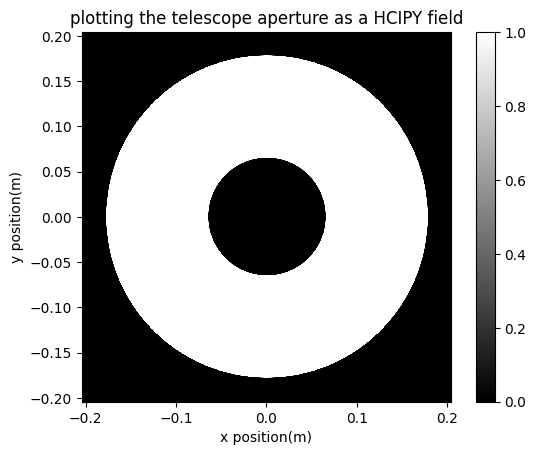

In [30]:
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

shimm_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,central_obscuration_ratio)
shimm_aperture = evaluate_supersampled(shimm_aperture_generator, pupil_grid, 4)


print(shimm_aperture.shape, '= num_pupil_pixels x num_pupil_pixels')


imshow_field(shimm_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.title('plotting the telescope aperture as a HCIPY field')
plt.show()

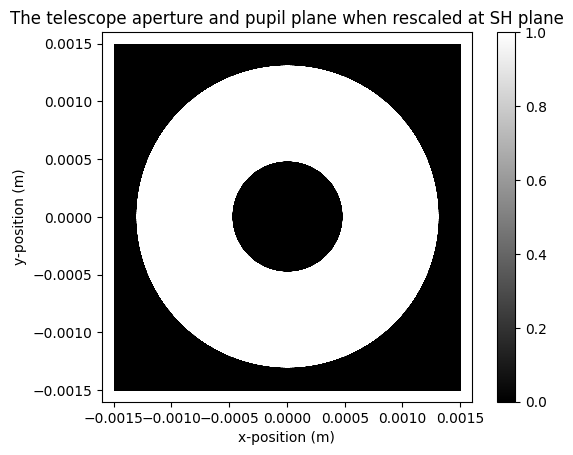

In [31]:
scaler_new = sh_diameter / pupil_grid_diameter  # we scaled the pupil grid to match the sh array
new_pupil_grid = pupil_grid.scaled(scaler_new)
new_shimm_aperture_generator = make_obstructed_circular_aperture(scaler_new * telescope_diameter,central_obscuration_ratio)
new_shimm_aperture = evaluate_supersampled(new_shimm_aperture_generator, new_pupil_grid, 4)

imshow_field(new_shimm_aperture, cmap='gray')
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.xlim(-0.0016, 0.0016)
plt.ylim(-0.0016, 0.0016)
plt.title('The telescope aperture and pupil plane when rescaled at SH plane')
plt.colorbar()
plt.show()

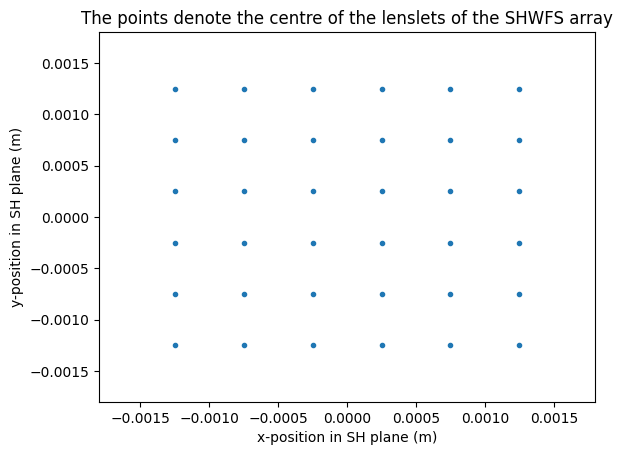

In [32]:

magnifier = Magnifier(scaler_new)


# print(pupil_grid_diameter, 'in m', 'is the diameter of the pupil plane just after telescope captures light')
# print(telescope_diameter, 'in m', 'is the diameter of the telescope aperture, or in other words the diameter of illuminated plane')

# print(sh_diameter, 'in m', 'is the sh_diameter = sh_pitch * num_lenslets')
# print(telescope_diameter * scaler_new, 'is the aperture of the telescope in the scaled frame on the SH plane')

lens_arr = np.arange(-sh_diameter/2 + sh_pitch/2, sh_diameter/2 - sh_pitch/2 + sh_pitch, sh_pitch) # we have rescaled the pupil plane to the sh plane
# print(*lens_arr, 'are positions of centres of the lenslets along xaxis')

lens_grid = CartesianGrid(SeparatedCoords((lens_arr, lens_arr)))
plt.plot(lens_grid.x, lens_grid.y, '.')
plt.xlim([-0.0018, 0.0018])
plt.ylim([-0.0018, 0.0018])
plt.xlabel('x-position in SH plane (m)')
plt.ylabel('y-position in SH plane (m)')
plt.title('The points denote the centre of the lenslets of the SHWFS array')
plt.show

# print(lens_grid.x, lens_grid.y)

x_pts = list(set(lens_grid.x))
y_pts = list(set(lens_grid.y)) 

x_pts = sorted(x_pts)
y_pts = sorted(y_pts)

# print(x_pts, y_pts)

edges = np.arange(min(x_pts)-sh_pitch/2, max(x_pts)+sh_pitch, sh_pitch) 
# print(edges)


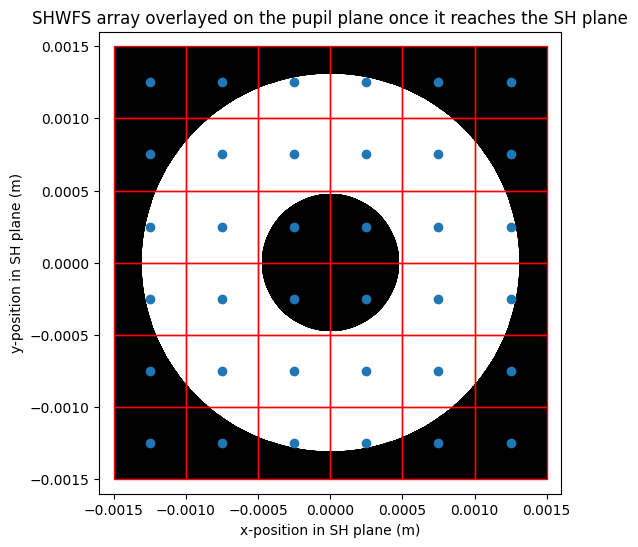

In [33]:

fig, ax = plt.subplots(figsize=(6, 6))

imshow_field(new_shimm_aperture, cmap='gray')

x_pts = list(set(lens_grid.x))
y_pts = list(set(lens_grid.y)) 

x_pts = sorted(x_pts)
y_pts = sorted(y_pts)

edges = np.arange(min(x_pts)-sh_pitch/2, max(x_pts)+sh_pitch, sh_pitch)

for i in edges[0:len(edges)-1]:
    for j in edges[0:len(edges)-1]:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rectangle)


ax.plot(lens_grid.x, lens_grid.y, 'o')
ax.set_xlim([-0.0016, 0.0016])
ax.set_ylim([-0.0016, 0.0016])
ax.set_xlabel('x-position in SH plane (m)')
ax.set_ylabel('y-position in SH plane (m)')
ax.set_title('SHWFS array overlayed on the pupil plane once it reaches the SH plane')
plt.show()

# print(lens_grid.x)
# print(lens_grid.y)

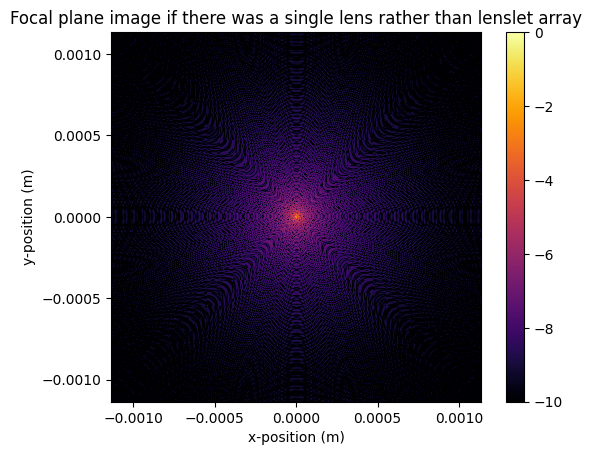

0.0011356573033707868 is the extent of the focal plane


In [34]:
pos_star = np.array([0.0, 0.0])  #np.array([4.84e-4,4.84e-4])

#wf = Wavefront(shimm_aperture, wavelength)
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)  
# is this to generalize wavefront based on arbitrary position of star and not just its centre ?
wf.total_power = 1


spatial_resolution = wavelength * f_number
focal_grid = make_focal_grid(q=5, num_airy=188, spatial_resolution=spatial_resolution) 
# focal_grid = make_focal_grid(q=4.6, num_airy=383.5, spatial_resolution=spatial_resolution)  
# required q is calculated from (spatial_resolution/pixel_size), comes out about 4.6. 
# Then num_airy is calculated by (num_lenslets*sh_pitch/spatial_reso), comes out 188 (should i use this?)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-10)
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.title('Focal plane image if there was a single lens rather than lenslet array')
plt.colorbar()
plt.show()

print(spatial_resolution * 188, 'is the extent of the focal plane')

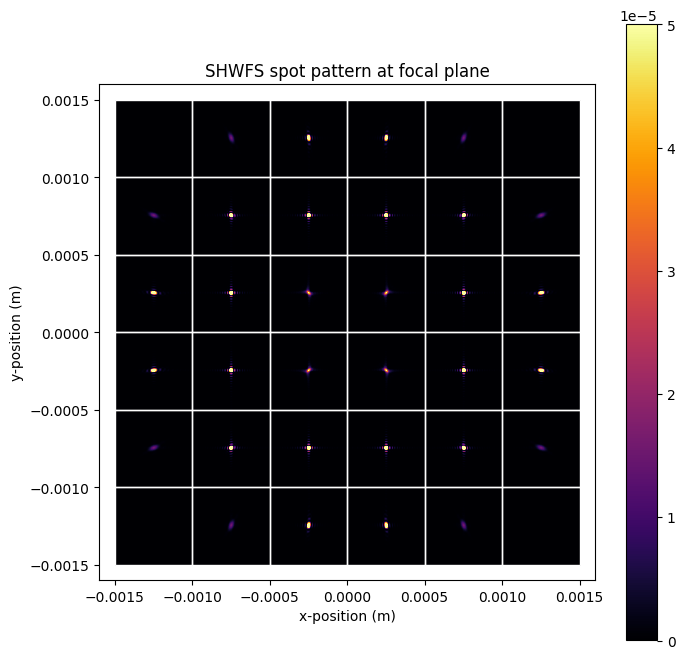

In [35]:
from hcipy.optics import MicroLensArray
lenslet_array = MicroLensArray(pupil_grid.scaled(scaler_new), lens_grid, focallength_l)
SHWFS = ShackHartmannWavefrontSensorOptics(pupil_grid.scaled(scaler_new), lenslet_array)


camera = NoiselessDetector(focal_grid)  # (new_pupil_grid)

pos_star = np.array([0,0]) #[4.84e-5,0.0])  #np.array([4.84e-4,4.84e-4])
wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
#wf = Wavefront((np.sqrt(2.512))**1 *shimm_aperture, wavelength) #to increase magnitude of star by one multiply shimm_aperture by sqrt(2.512)?
wf.total_power = 1

camera.integrate(SHWFS(magnifier(wf)),1)

image_ref = camera.read_out()

fig, ax = plt.subplots(figsize=(8, 8))

imshow_field(image_ref, cmap='inferno', vmax=5.0e-5)#, grid_units= pixel_size, vmax=5.0e-5)
#plt.imshow(image_ref.reshape((1764,1764)), cmap='inferno', vmax=1.0e-5)


for i in edges[0:len(edges)-1]:
    for j in edges[0:len(edges)-1]:
        rectangle = patches.Rectangle((i, j), sh_pitch, sh_pitch, linewidth=1, edgecolor='w', facecolor='none')
        ax.add_patch(rectangle)

        
ax.set_xlim([-0.0016, 0.0016])
ax.set_ylim([-0.0016, 0.0016])
ax.set_xlabel("x-position (m)")
ax.set_ylabel("y-position (m)")
ax.set_title('SHWFS spot pattern at focal plane')
plt.colorbar()
plt.show()


In [36]:
shwfse = ShackHartmannWavefrontSensorEstimator(SHWFS.mla_grid, SHWFS.micro_lens_array.mla_index)
slopes_ref = shwfse.estimate([image_ref]) / focallength_l


print(slopes_ref)

[[ 5.01954913e-03  1.88280041e-04  2.60741902e-05 -2.60741902e-05
  -1.88280041e-04 -5.01954913e-03  3.20021427e-04  2.76499274e-05
  -8.48413398e-07  8.48413398e-07 -2.76499274e-05 -3.20021427e-04
   1.31856269e-04 -3.38999920e-06 -2.05756644e-04  2.05756644e-04
   3.38999920e-06 -1.31856269e-04  1.31856269e-04 -3.38999920e-06
  -2.05756644e-04  2.05756644e-04  3.38999920e-06 -1.31856269e-04
   3.20021427e-04  2.76499274e-05 -8.48413398e-07  8.48413398e-07
  -2.76499274e-05 -3.20021427e-04  5.01954913e-03  1.88280041e-04
   2.60741902e-05 -2.60741902e-05 -1.88280041e-04 -5.01954913e-03]
 [ 5.01954913e-03  3.20021427e-04  1.31856269e-04  1.31856269e-04
   3.20021427e-04  5.01954913e-03  1.88280041e-04  2.76499274e-05
  -3.38999920e-06 -3.38999920e-06  2.76499274e-05  1.88280041e-04
   2.60741902e-05 -8.48413398e-07 -2.05756644e-04 -2.05756644e-04
  -8.48413398e-07  2.60741902e-05 -2.60741902e-05  8.48413398e-07
   2.05756644e-04  2.05756644e-04  8.48413398e-07 -2.60741902e-05
  -1.8828

In [37]:
seeing = 4.0#0.25 #in arcseconds, at Hanle. but at what wavelength?
outer_scale = 40 # meter  ##what value for Hanle?
tau0 = 0.005 # seconds  ##what value for Hanle?

fried_parameter = 0.068 # seeing_to_fried_parameter(seeing)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.3f}m'.format(fried_parameter))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))


# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)   # its computation speed also changes becoz, it is made of pupil plane

# phase_screen_phase = layer.phase_for(wavelength) # in radian
# phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

# imshow_field(phase_screen_opd, cmap='RdBu')#,vmin=-4, vmax=4)
# plt.colorbar()

r0   = 0.068m
L0   = 40.0m
tau0 = 5.0ms
v    = 4.3m/s


[-1.16584600e-08 -1.36022106e-09  2.98622156e-09  2.76210321e-08
  2.98622156e-09 -1.36022106e-09 -1.16584600e-08]


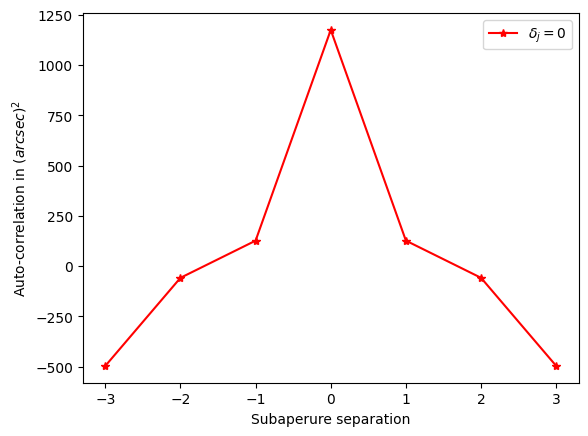

In [38]:
# give the indices of the lenslets which are not to be considered
non_lenslets_indices = np.array([0, 1, 2, 3, 4, 5, 
                                 6, 11, 
                                 12, 14, 15, 17, 
                                 18, 20, 21, 23, 
                                 24, 29, 
                                 30, 31, 32, 33, 34, 35])   # this should be treated as an user input based on telescope geometry and SH lenslet array
                                                            # in this case 6x6

good_lenslets_indices = np.array([7, 8, 9, 10, 
                                  13, 16, 
                                  19, 22, 
                                  25, 26, 27, 28])   # the ones whose slope we take into account

# defining the lenslet or subaperture separations in units of subaperture itself
del_i = np.array([-3, -2, -1, 0, 1, 2, 3])
del_j = np.array([0])
del_i_j = np.array([[i, j] for i in del_i for j in del_j])  # (all possible lenslet separation in 2 dimension for the given geometry 6x6 and obscure lenslets)


Auto_corr_arr_x = np.zeros(7)
frames = 1

for i in range(frames):

    ## CREATION OF ATMOSPHERE TURBULENCE LAYER
    layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)   # its computation speed also changes becoz, it is made of pupil plane
    phase_screen_phase = layer.phase_for(wavelength) # in radian
    phase_screen_opd = phase_screen_phase * (wavelength / (2 * np.pi)) * 1e6

    
    ## CREATION OF WAVEFRONT WHICH WILL PROPAGATE THROUGH THE ATMOSPHERE
    pos_star = np.array([0.0,0.0])  #np.array([4.84e-4,4.84e-4])
    wf = Wavefront(shimm_aperture * np.exp(2j * np.pi * np.dot(pos_star, pupil_grid.coords) / wavelength), wavelength)
    wf_atmos= layer(wf)  # made to propagate thru atmosphere
    camera.integrate(SHWFS(magnifier(wf_atmos)), 1)
    image_ref_atmos = camera.read_out()


    ## SLOPES OF THE IMAGES ON EACH LENSLET
    shwfse = ShackHartmannWavefrontSensorEstimator(SHWFS.mla_grid, SHWFS.micro_lens_array.mla_index)
    slopes_ref_atmos = shwfse.estimate([image_ref_atmos]) / focallength_l
    slopes_ref_atmos = slopes_ref_atmos - slopes_ref

    ## CALCULATIONG THE UNBIASED SLOPES ON EACH LENSLET, BY REMOVING THE AVERAGE SLOPE OVER ALL LENSLET OR SUBAPERTURE
    slopes_ref_atmos_x = slopes_ref_atmos[0]
    for i in non_lenslets_indices:
        slopes_ref_atmos_x[i] = 0
    # but we also need to subtract out the average slope across all the lenslets
    avg_x_slope = np.sum(slopes_ref_atmos_x) / 12
    bias_slope_x = np.ones(36) * avg_x_slope
    non_bias_slope_x = slopes_ref_atmos_x - bias_slope_x


    ## CALCULATING THE AUTO-CORRELATION FUNCTION
    auto_corr_x = []
    for m in del_i_j:        
        S_x = 0
        N_x = 0  # number of overlaps found
        for n in good_lenslets_indices:        # remember m and n act as indices for the slope array
            if (n + 6*m[0] + m[1]) in good_lenslets_indices:        # this condition is based o geometry so the user has to change it according to need
                S_x = S_x + (non_bias_slope_x[n] * non_bias_slope_x[n + 6*m[0] + m[1]])
                N_x = N_x + 1
            else:
                S_x = S_x + 0 
                N_x = N_x + 0
        A_x_del_ij = S_x / N_x
        auto_corr_x.append(A_x_del_ij)
    auto_corr_x = np.array(auto_corr_x)

    Auto_corr_arr_x = Auto_corr_arr_x + auto_corr_x
    print(auto_corr_x)

final_averaged_auto_corr_x = Auto_corr_arr_x / frames    
plt.plot(del_i, final_averaged_auto_corr_x * (206265**2), '*-', color='red', label='$\delta_j = 0$')
plt.xlabel('Subaperure separation')
plt.ylabel('Auto-correlation in $(arcsec)^2$')
plt.legend()
plt.show()


    


In [39]:
# print(final_averaged_auto_corr_x * (206265**2))


In [40]:
# Now I plot all the auto-correlation together

